## Hanly-Tubbs Spatial Data

In [1]:
## Import packages
import os
import requests
import pandas as pd
import json
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
import shapely.geometry
import contextily as cx
import xarray as xr
#import urllib
import netCDF4
import seaborn as sns
import ipywidgets as widgets
from IPython.display import display
from shapely.ops import transform
from shapely import wkb
from geopy.geocoders import Nominatim

/usr/local/lib/python3.9/site-packages/geopandas/_compat.py:111: UserWarning: The Shapely GEOS version (3.10.2-CAPI-1.16.0) is incompatible with the GEOS version PyGEOS was compiled with (3.10.1-CAPI-1.16.0). Conversions between both will be slow.
  warnings.warn(


In [4]:
## Set variables to read files

data_url = "https://github.com/hollifknight/HanlyTubbsDashboard/"

housing_url = data_url + "blob/master/Data/SantaRosaGeo.csv"
weather_url = data_url + "blob/master/Data/weather_master.csv"
psql_url = data_url + 'blob/master/Data/PSQL_SonomaCountyHousing.csv'

In [6]:
## function to take CSV file from github
import pandas as pd

def read_file(url):

    """
    Takes GitHub url as an argument,
    pulls CSV file located @ github URL.

    """

    url = url + "?raw=true"
    df = pd.read_csv(url)
    return df

In [8]:
## Import census block data, which includes housing and population density

psql = read_file(psql_url)
psql['geom'] = psql['wkb_geometry'].apply(wkb.loads, hex=True)
housing_density = psql.set_geometry("geom", crs="EPSG:4326")

In [17]:
## Get housing geometries

santa_rosa = read_file(housing_url)


sr = santa_rosa[santa_rosa['GeoLocation'].notna()]
sr = sr.reset_index(drop=True)

geometry = []
latlong = []
for address, coords in sr['GeoLocation']:
    point = shapely.geometry.Point(coords)
    geometry.append(point)
    latlong.append(coords)

sr = sr.join(pd.DataFrame(geometry, columns=["geom"]))
sr = sr.join(pd.DataFrame(latlong, columns = ['Lat', 'Long']))

gdf = sr.set_geometry("geom")

gdf['geom'] = gdf.geometry.map(lambda point: shapely.ops.transform(lambda x, y: (y, x), point))

gdf = gdf.set_geometry("geom", crs="EPSG:4326")

/usr/local/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:122: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)


In [36]:
#export_csv = gdf.to_csv("/Users/27249/Desktop/GitRepos/HanlyTubbsDashboard/Data/SantaRosaGeo.csv")

In [25]:
## Read in fire geometries 
def UrlToDf(url):
    ## Use requests package to access API
    request = requests.get(url)
    
    ## Convert to JSON
    data = request.json()
    
    ## Select feature set
    features = data['features']
    
    ## Normalize and convert to DataFrame
    df = pd.DataFrame(pd.json_normalize(features))
    
    return df


url_1960s = "https://egis.fire.ca.gov/arcgis/rest/services/FRAP/FirePerimeters/MapServer/7/query?where=1%3D1&outFields=*&outSR=4326&f=json"
df60 = UrlToDf(url_1960s)

url_2010s = "https://egis.fire.ca.gov/arcgis/rest/services/FRAP/FirePerimeters/MapServer/2/query?where=1%3D1&outFields=*&outSR=4326&f=json"
df10 = UrlToDf(url_2010s)

In [30]:
## Append datasets & select fires of interest
df_append = df60.append(df10)
fire_df = df_append.loc[(df_append['attributes.FIRE_NAME'] == "C. HANLY") | 
                        (df_append['attributes.FIRE_NAME'] == 'TUBBS')]

def MakeGeo(df, geo_column, shape, spacial_ref):
    ## inputs: dataframe, initial geometry column, shapely geometry, and geometry spacial reference
    
    ## Reset index for joining data
    df = df.reset_index()
    
    ## Unstack nested list in Esri Geometry Column 
    df_geometry = df[geo_column]
    df = df.join(pd.DataFrame(df_geometry.apply(pd.Series).stack()).reset_index())
    
    ## Rename new column
    df.columns = [*df.columns[:-1], 'geom']
    ## Tranform column to list of tuples (required for polygon data)
    df['geom'] = list(tuple(x) for x in df['geom'])
    
    ## Create geometry by calling shapely.geometry
    df['geometry'] = df.apply(lambda row: shape(row['geom']), axis=1)
    
    ## Drop unnecessary column
    df = df.drop(columns = ['level_0', 'level_1', 'geom'])
    
    ## Set geometry column and specify the geometry's spacial reference
    gdf = df.set_geometry("geometry", crs = spacial_ref)
    ## Return GeoDataFrame
    return gdf


fire_gdf = MakeGeo(fire_df, 'geometry.rings', shapely.geometry.Polygon, "EPSG:4326")

/var/folders/lk/ty0zvm7x1711sth69gl25hsr0000gr/T/ipykernel_39322/402803761.py:2: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_append = df60.append(df10)


In [26]:
## Make a copy of census block geometry, as this column will disappear once merged with the second dataset
housing_density['SavedGeometry'] = housing_density.geometry

In [27]:
## Spatial join: this merges the two datasets on geometry. Each address will now have a census block
df = gdf.sjoin(housing_density)

## Remove duplicate parcels
df = df.drop_duplicates("ParcelNumber").reset_index(drop=True)

In [28]:
## Format datasets for mapping
blocks1964 = df[df['BuildingPrimary:YearBuilt'] <=1964].groupby(['blockid10'], 
                                                                as_index=False)['ParcelNumber'].count()
blocks1964 = blocks1964.merge(df[['blockid10', 'BlockGeometry']], how="left")
blocks1964 = blocks1964.drop_duplicates("blockid10")
blocks1964 = blocks1964.set_geometry("BlockGeometry", crs="EPSG:4326")


blocks2017 = df.groupby(['blockid10'], as_index=False)['ParcelNumber'].count()
blocks2017 = blocks2017.merge(df[['blockid10', 'BlockGeometry']], how="left")
blocks2017 = blocks2017.drop_duplicates("blockid10")
blocks2017 = blocks2017.set_geometry("BlockGeometry", crs="EPSG:4326")

In [ ]:
## Import weather dataset

df2 = read_file(weather_url)

## create filter widget

var_keys = list(df2.loc[:, "Net shortwave radiation flux (W m-2)":"Downward longwave radiation flux (W m-2)"].columns.values)
Variable = widgets.Select(options=var_keys, 
                         layout = widgets.Layout(width='400px', height='200px'),
                         description="Feature", disabled=False)

## create and update plot with widget

def update_plot(Variable):
    
    fig, ax = plt.subplots(figsize=(8,8))
    ax.clear()
    
    hanly_start =  38 #263 # Sept. 19, 1964
    hanly_end = (hanly_start + 1)
    tubbs_start = 40 #281 # Oct. 8 - 31, 2017
    tubbs_end = (tubbs_start + 3)

        
    g1 = sns.lineplot(data=df2, x="Week", y=Variable, palette='RdBu', hue="Year", alpha=0.7, legend=True#, ci=None
                     )

    plt.axvspan(hanly_start, hanly_end, label="Hanly Fire", color="maroon", alpha=0.5)
    plt.axvspan(tubbs_start, tubbs_end, label = "Tubbs Fire", color="steelblue", alpha=0.5)


    plt.xlim(18, 44)
    plt.title(Variable +" by Week", fontsize=14)

    plt.xticks(np.arange(18, 46, 2), labels=['5/1', '5/15', '5/29', '6/12', '6/26', '7/10', '7/24', '8/7', '8/21', 
                                            '9/4', '9/18', '10/2', '10/16', '10/30'])
    plt.legend()
    plt.show()

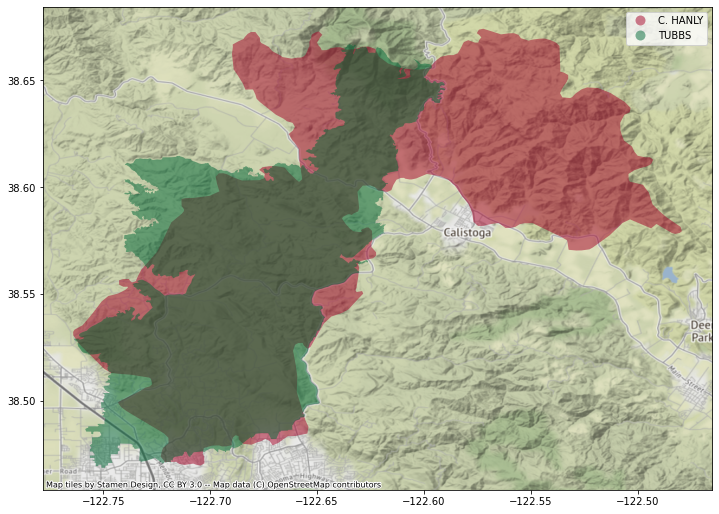

In [33]:
fig, ax = plt.subplots(figsize=(12,12))

fire_gdf.plot(ax=ax, column='attributes.FIRE_NAME', cmap='RdYlGn',legend=True,  alpha=0.5, 
                 legend_kwds={'loc': 'upper right'})

cx.add_basemap(ax, crs=fire_gdf.crs.to_string()
              )



plt.show()

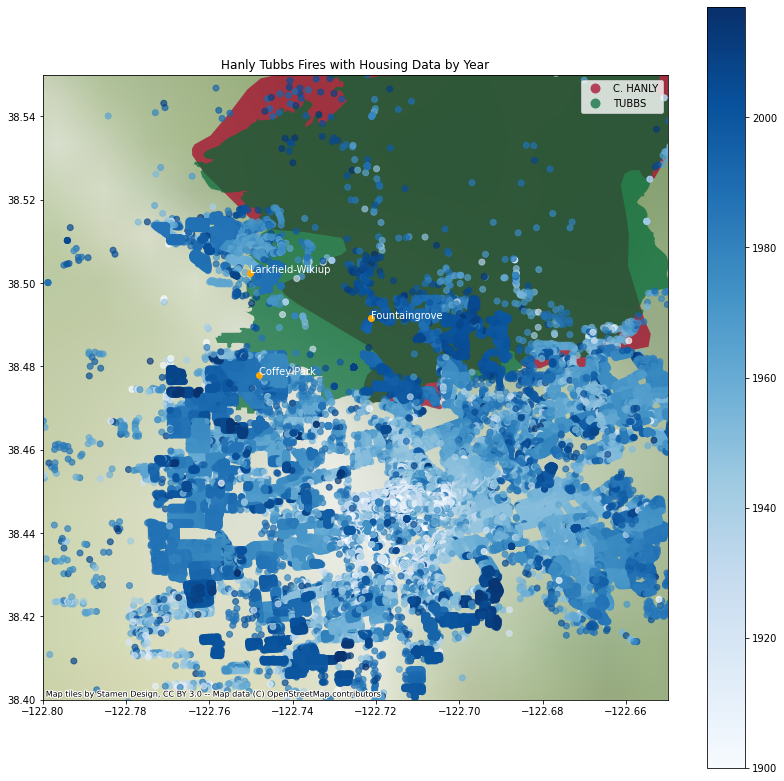

In [35]:
fig, ax = plt.subplots(figsize=(14,14))

fire_gdf.plot(ax=ax, column='attributes.FIRE_NAME', cmap='RdYlGn',legend=True,  alpha=0.7, 
                 legend_kwds={'loc': 'upper right'})

gdf.plot(ax=ax, column='BuildingPrimary:YearBuilt', cmap='Blues',legend=True,  
         alpha=0.7, aspect=1, vmin=1900, vmax=2017)




cx.add_basemap(ax, crs=gdf.crs.to_string())

plt.xlim(-122.8, -122.65)
plt.ylim(38.4, 38.55)


long = [-122.7479789, -122.7502105, -122.7212738]
lat = [38.4780661, 38.5025241, 38.4915694]
locs = ['Coffey Park', 'Larkfield-Wikiup', 'Fountaingrove']

for x, y, name in zip(long, lat, locs):
    plt.scatter(x=x, y=y, c="orange")
    plt.annotate(name, (x, y), c="white")

plt.title("Hanly Tubbs Fires with Housing Data by Year")

plt.show()

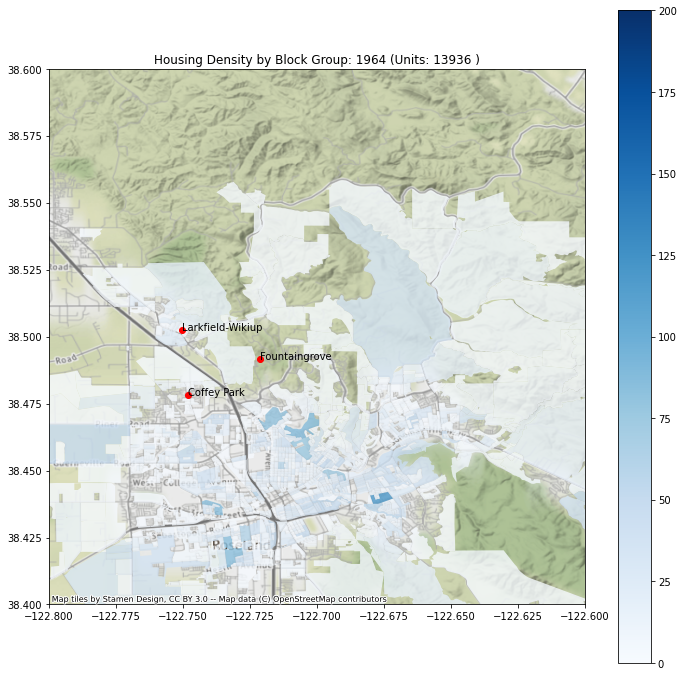

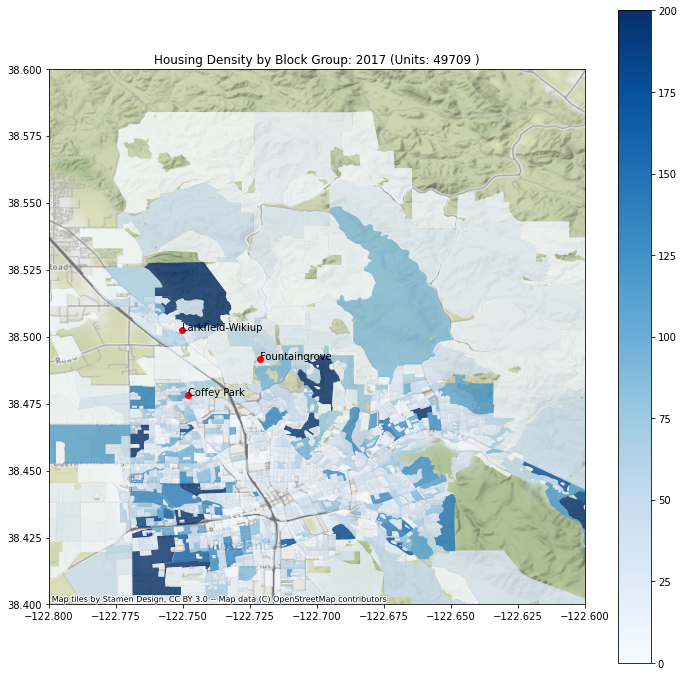

In [29]:
## 1964 Density
units1964 = blocks1964['ParcelNumber'].sum()
fig1, ax1 = plt.subplots(figsize=(12,12))
blocks1964.plot(column="ParcelNumber",cmap='Blues', ax=ax1
                   ,legend=True, figsize=(10,10), vmin=0, vmax=200, alpha=0.8)
cx.add_basemap(ax1, crs=df.crs.to_string()
              )
long = [-122.7479789, -122.7502105, -122.7212738]
lat = [38.4780661, 38.5025241, 38.4915694]
locs = ['Coffey Park', 'Larkfield-Wikiup', 'Fountaingrove']

for x, y, name in zip(long, lat, locs):
    plt.scatter(x=x, y=y, c="red")
    plt.annotate(name, (x, y), c="black")

plt.xlim(-122.8, -122.6)
plt.ylim(38.4, 38.6)
plt.title("Housing Density by Block Group: 1964 " +"(Units: " + str(units1964) + " )")
plt.show()


## 2017 Density
units2017 = blocks2017['ParcelNumber'].sum()
fig1, ax1 = plt.subplots(figsize=(12,12))
blocks2017.plot(column="ParcelNumber",cmap='Blues', ax=ax1
                   ,legend=True, figsize=(10,10), vmin=0, vmax=200, alpha=0.8)
cx.add_basemap(ax1, crs=df.crs.to_string()
              )
long = [-122.7479789, -122.7502105, -122.7212738]
lat = [38.4780661, 38.5025241, 38.4915694]
locs = ['Coffey Park', 'Larkfield-Wikiup', 'Fountaingrove']

for x, y, name in zip(long, lat, locs):
    plt.scatter(x=x, y=y, c="red")
    plt.annotate(name, (x, y), c="black")

plt.xlim(-122.8, -122.6)
plt.ylim(38.4, 38.6)
plt.title("Housing Density by Block Group: 2017 " +"(Units: " + str(units2017) + " )")
plt.show()

In [32]:
display(widgets.interact(update_plot, Variable=Variable))

interactive(children=(Select(description='Feature', layout=Layout(height='200px', width='400px'), options=('Ne…

<function __main__.update_plot(Variable)>